<a href="https://colab.research.google.com/github/GermanOmar/LaserVWC/blob/master/LaserWelding1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mechanical vibration effect over the microhardness of AISI A36 steel in a lap configuration joints by laser welding


<a href="https://ibb.co/VH5s6tP"><img src="https://i.ibb.co/PT0dkNf/LaserVWC.png" WIDTH="420" HEIGHT="300"  border="0"></a>

 Libraries

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings("ignore")

 Upload database:

In [2]:
!git clone https://github.com/GermanOmar/LaserVWC

Cloning into 'LaserVWC'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 9 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (9/9), done.


In [3]:
#Experimental data
data = pd.read_table('Df.txt') 
data.describe()


,Amplitude,Frequency,Hardness
count,44.000000,44.000000,44.000000
mean,0.394545,523.401818,167.522727
std,0.131847,379.779496,13.599741
min,0.200000,0.000000,143.000000
25%,0.280000,210.082500,158.500000
50%,0.400000,585.690000,169.000000
75%,0.480000,831.985000,177.250000
max,0.560000,1034.510000,197.000000


<a href="https://ibb.co/cgFcLwg"><img src="https://i.ibb.co/JB7RQqB/Contour-Plot.png" WIDTH="500" HEIGHT="325"  border="0"></a>


Setting inputs - output:

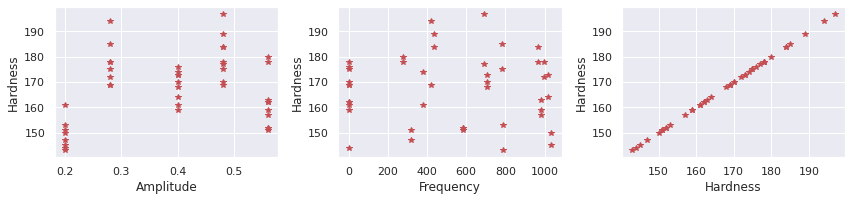

In [4]:
fields = [ 'Amplitude',  'Frequency','Hardness']
import seaborn as sns
sns.set()

fig = plt.figure()
fig.set_size_inches((12,8))
for i, field in enumerate(fields):
  plt.subplot(3, 3, i + 1)
  plt.plot(data[field], data['Hardness'], 'r*')
  plt.xlabel(field)
  plt.ylabel('Hardness')

plt.tight_layout()

X=data[[ 'Amplitude',  'Frequency']]
Y=data['Hardness'][:,None]


#fig.tight_layout()

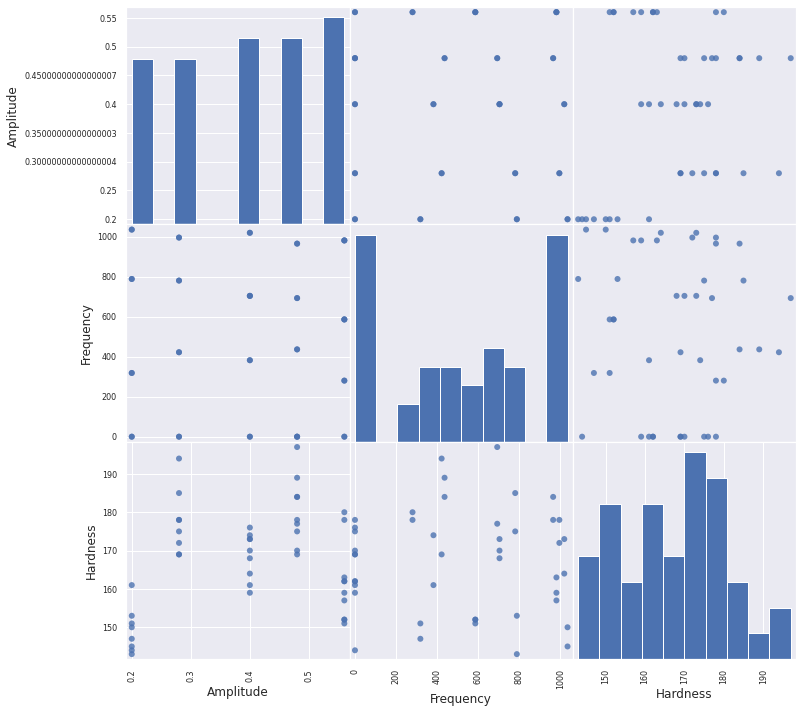

In [ ]:
from pandas.plotting import scatter_matrix

#DISPLAY MATRIX - identificar correlacion entre variables
scatter_matrix(data, alpha=0.8, marker='o', figsize = (12,12))

import warnings
warnings.filterwarnings("ignore")

Normalizing


In [ ]:
def normalize(X, X_mu, X_std):
  return (X - X_mu)/X_std

def denormalize(Xn, X_mu, X_std):
  return Xn*X_std + X_mu

X_std = X.std(0)
X_mu = X.mean(0)
Xn = normalize(X, X_mu, X_std)

Y_std = Y.std(0)
Y_mu = Y.mean(0)
Yn = normalize(Y, Y_mu, Y_std)

 Split data

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1234)
print('training samples:', X_train.shape[0],  ' test samples:', X_test.shape[0])

training samples: 35  test samples: 9


In [33]:
X_test



,Amplitude,Frequency
29,0.48,436.08
17,0.40,0.00
33,0.48,964.48
40,0.56,585.69
8,0.28,0.00
13,0.28,779.86
4,0.20,787.82
20,0.40,703.46
10,0.28,421.76


#Results:

###GBR 

In [26]:
from sklearn.ensemble import GradientBoostingRegressor
#KERNEL
#GBR=GradientBoostingRegressor(n_estimators=100, random_state=0)
GBR=GradientBoostingRegressor(n_estimators=2000, random_state=42, learning_rate=0.1 )

#START TRAINING
GBR.fit(X_train,y_train)
#PREDICTION
y_pred=GBR.predict(X_test)

#EVAL
from sklearn.metrics import mean_squared_error as MSE
MSE_test = MSE(y_test, y_pred)

 
print("-Gradient boosting regressor-")
print("-----------------------------")

print('MSE test:', MSE_test)

print()

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 

#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()


-Gradient boosting regressor-
-----------------------------
MSE test: 141.02777777777226

R2:  0.4762859893636735
RMSE:  11.87551168488214
MAE:  9.611111111110809
IM:  15.286448604330133



### GPs

In [8]:
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
 
GP=GPR(kernel=kernel, n_restarts_optimizer=20, alpha=0.01, normalize_y=True)
 
#Training
GP.fit(X_train,y_train)
 
#Testing
y_star_train = GP.predict(X_train)
y_pred = GP.predict(X_test)
 
from sklearn.metrics import mean_squared_error
MSE_test = mean_squared_error(y_test, y_pred)
MSE_train = mean_squared_error(y_train, y_star_train)
 
print("Gaussian Process")
print('MSE train:', MSE_train)
print('MSE test:', MSE_test)
print("MSE train < MSE test?", MSE_train < MSE_test)
print()
from sklearn.metrics import r2_score
R2_train=r2_score(y_train, y_star_train)
print('R2_train: ',R2_train)
R2_test=r2_score(y_test, y_pred)
print('R2_test: ',R2_test)
print()
""" 
RE=100 * abs(y_test - y_pred) / y_test
print('Relative error (%): ',RE)
"""
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 
#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()

Gaussian Process
MSE train: 15.823810074955285
MSE test: 141.0397976967308
MSE train < MSE test? True

R2_train:  0.896953020350751
R2_test:  0.47624135276750434

R2:  0.47624135276750434
RMSE:  11.876017754143465
MAE:  9.61173280099478
IM:  15.287234159749126



### RFR

In [28]:
from sklearn.ensemble import RandomForestRegressor
#KERNEL
RFR=RandomForestRegressor(n_estimators=2000,max_depth=20)

#START TRAINING
RFR.fit(X_train,y_train)
#PREDICTION
y_pred=RFR.predict(X_test)

#EVAL
from sklearn.metrics import mean_squared_error as MSE
MSE_test = MSE(y_test, y_pred)

print("-----------------------------")

print('MSE test:', MSE_test)

print()

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 

#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()

-----------------------------
MSE test: 114.24449171064907

R2:  0.5757471195414188
RMSE:  10.688521493202373
MAE:  9.099119554673756
IM:  14.04344896695512



### XGB

In [10]:
import pickle
import xgboost as xgb

xgbr = xgb.XGBRegressor(verbosity=0, n_estimators=2000, max_depth=20)
xgbr.fit(X_train, y_train)
y_pred = xgbr.predict(X_test)

In [11]:
print(xgbr)



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=20, min_child_weight=1, missing=None, n_estimators=2000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=0)


In [12]:
score = xgbr.score(X_test, y_test)  
print("Training score: ", score)

Training score:  0.4763467765945708


In [13]:
print("-XGBRegressor -")
print("------------------")

#EVAL
from sklearn.metrics import mean_squared_error as MSE
MSE_test = MSE(y_test, y_pred)

print('MSE test:', MSE_test)

print()

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 

#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()

-XGBRegressor -
------------------
MSE test: 141.01140875208915

R2:  0.4763467765945708
RMSE:  11.874822472445183
MAE:  9.610748291015625
IM:  15.285682979956498



### AdaBoost

In [22]:
from sklearn.ensemble import AdaBoostRegressor

print(" AdaBoost -")
print("------------------")

Ada = AdaBoostRegressor(random_state=42, n_estimators=2000)
#START TRAINING
Ada.fit(X_train,y_train)
#PREDICTION
y_pred=Ada.predict(X_test)

#EVAL
from sklearn.metrics import mean_squared_error as MSE
MSE_test = MSE(y_test, y_pred)

print('MSE test:', MSE_test)

print()

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 

#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()

 AdaBoost -
------------------
MSE test: 111.96649219467395

R2:  0.5842065895943247
RMSE:  10.58142203083659
MAE:  8.716161616161616
IM:  13.715350876804422



### MLP

In [25]:
from sklearn.neural_network import MLPRegressor

MLP = MLPRegressor(hidden_layer_sizes=8,solver='lbfgs',learning_rate='adaptive',activation='relu',random_state=42, max_iter=2000)
#MLP = MLPRegressor(hidden_layer_sizes=(1000,1000,1000), activation='relu', solver='adam', max_iter=800)

#START TRAINING
MLP.fit(X_train,y_train)
#PREDICTION
y_pred=MLP.predict(X_test)

print()

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 

#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()



R2:  -0.11446303742925346
RMSE:  10.58142203083659
MAE:  15.410555180434066
IM:  18.72681849716265



# Comparisson

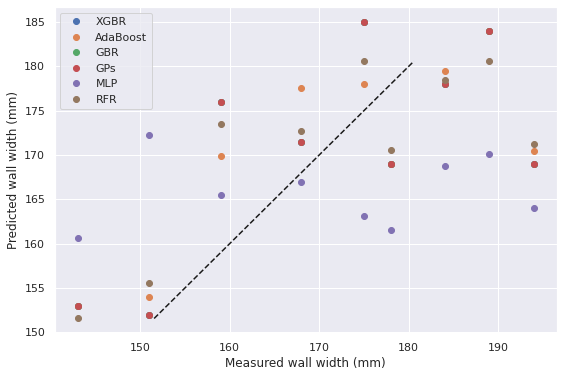

In [29]:
models = [xgbr, Ada, GBR,  GP, MLP, RFR ]
labels = ['XGBR', 'AdaBoost', 'GBR',   'GPs',  'MLP', 'RFR']

fig = plt.figure()
fig.set_size_inches((9,6))

for mod, label in zip( models, labels): 
  y_pred = mod.predict(X_test)
  plt.plot(y_test, y_pred, 'o' ,label = label)

plt.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], 'k--')
plt.ylabel('Predicted wall width (mm)')
plt.xlabel('Measured wall width (mm)')
plt.legend()

# CROSS-VALIDATION

In [17]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error 
from sklearn.model_selection import cross_val_score as CV

import warnings
warnings.filterwarnings('ignore')

models = [xgbr, Ada, GBR,  GP,  MLP, RFR ]
labels = ['XGBR', 'AdaBoost', 'GBR',   'GPs',  'MLP', 'RFR']
IMS = []

print("--------------------------------------------------------------")
print("%5s | %5s | %5s | %5s | %5s " % ("ML algorithm",  "CV-R2", "CV-MSE", "CV-MAE", "IM"))
print("--------------------------------------------------------------")

for mod, label in zip( models, labels): 
  y_star_train = mod.predict(X_train)
 
  scoreR2 = CV(mod, X_train, y_train, cv=5, scoring='r2')
  #print(-1*scoreR2)
  scoreMSE = CV(mod, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
  #print(-1*scoreMSE)
  scoreMAE = CV(mod, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
  #print(-1*scoreMAE)
  IM=np.sqrt(((1-scoreR2)**2) + (scoreMSE) + (scoreMAE**2) )
  #print("IM: ", IM)
  
 
  print("%15s | %.4f | %.4f | %.4f | %.4f " % (label,  scoreR2.mean(), -1*scoreMSE.mean(), -1*scoreMAE.mean() , np.sqrt(((1-scoreR2.mean())**2) + (-1*scoreMSE.mean()) + (scoreMAE.mean()**2) )))
print("--------------------------------------------------------------")

--------------------------------------------------------------
ML algorithm | CV-R2 | CV-MSE | CV-MAE |    IM 
--------------------------------------------------------------
           XGBR | -0.0276 | 102.0250 | 7.4073 | 12.5678 
       AdaBoost | 0.1640 | 84.3917 | 7.2757 | 11.7485 
            GBR | 0.0892 | 90.3119 | 7.1662 | 11.9372 
            GPs | -0.3875 | 128.5608 | 8.6571 | 14.3329 
            MLP | -61.2917 | 6132.6141 | 55.4463 | 114.3991 
            RFR | 0.2467 | 77.5609 | 7.1988 | 11.3996 
--------------------------------------------------------------


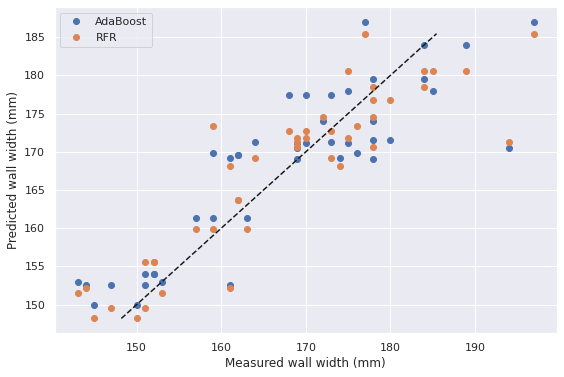

In [30]:
models = [Ada,  RFR ]
labels = [ 'AdaBoost','RFR']

fig = plt.figure()
fig.set_size_inches((9,6))

for mod, label in zip( models, labels): 
  y_pred = mod.predict(X)
  plt.plot(Y, y_pred, 'o' ,label = label)

plt.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], 'k--')
plt.ylabel('Predicted wall width (mm)')
plt.xlabel('Measured wall width (mm)')
plt.legend()

## Predictions:

In [34]:
X_test


,Amplitude,Frequency
29,0.48,436.08
17,0.40,0.00
33,0.48,964.48
40,0.56,585.69
8,0.28,0.00
13,0.28,779.86
4,0.20,787.82
20,0.40,703.46
10,0.28,421.76


In [35]:
X04=([[ 0.4,	0.0]])
HV=RFR.predict(X04)

In [36]:
HV

array([173.43866885])

In [39]:
#independet variables
fa=pd.read_table('eval.txt', header=None)

In [52]:
#dependet variables
hv=pd.read_table('evalHV.txt', header=None)

In [45]:
RFpred=RFR.predict(fa)

In [46]:
RFpred


array([152.22005952, 149.54318452, 151.55607619, 148.17922857,
       170.59925159, 171.27295   , 180.57805   , 174.53152143,
       173.43866885, 168.14666429, 172.71879048, 169.17884583,
       171.83415437, 180.58362897, 185.46551071, 178.4989623 ,
       163.73950357, 176.82385952, 155.55528333, 159.83034444])

In [49]:

ADApred=Ada.predict(fa)

In [50]:
ADApred

array([152.5       , 152.5       , 153.        , 150.        ,
       169.        , 170.45454545, 178.        , 174.        ,
       169.9       , 169.25      , 177.5       , 171.33333333,
       171.2       , 184.        , 187.        , 179.5       ,
       169.57142857, 171.55555556, 154.        , 161.33333333])

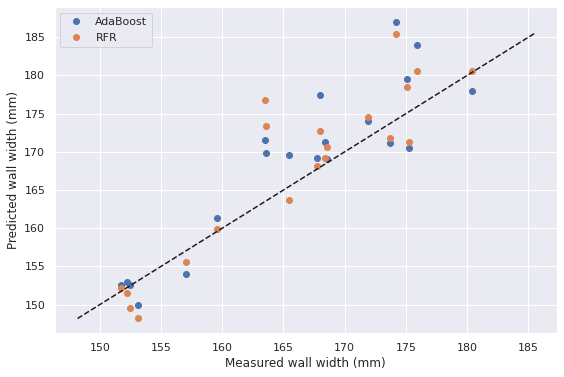

In [53]:
models = [Ada,  RFR ]
labels = [ 'AdaBoost','RFR']

fig = plt.figure()
fig.set_size_inches((9,6))

for mod, label in zip( models, labels): 
  y_pred = mod.predict(fa)
  plt.plot(hv, y_pred, 'o' ,label = label)

plt.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], 'k--')
plt.ylabel('Predicted wall width (mm)')
plt.xlabel('Measured wall width (mm)')
plt.legend()